# Transfer Learning

In [1]:
import numpy as np
import pandas as pd
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print('GPU', tf.test.gpu_device_name(), 'configured')

GPU /device:GPU:0 configured


Lets first show the images

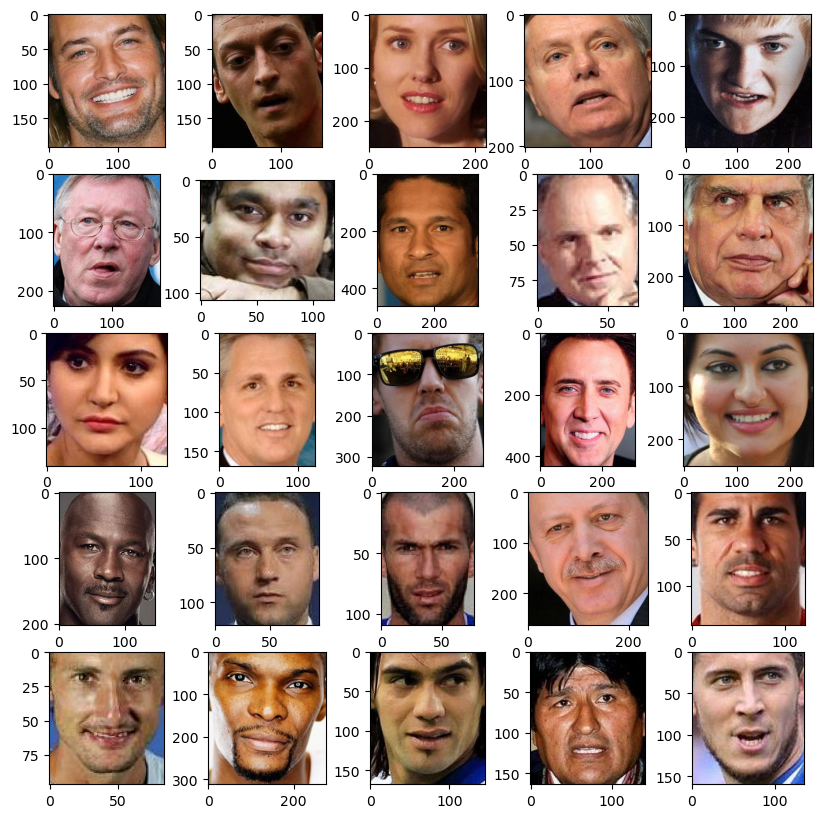

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_images_in_path(path):
    plt.figure(figsize=(10,10))
    images = os.listdir(path)
    for i, image_name in enumerate(images[:25]):
        plt.subplot(5,5,i+1)
        imagen = mpimg.imread(os.path.join(path, image_name))
        plt.imshow(imagen)
    
plot_images_in_path('/mnt/hdd/__Docencia/DataAnalysisWithPython/!!2023SepUH/lectures/large_datasets/face_front_profile/frontal/')


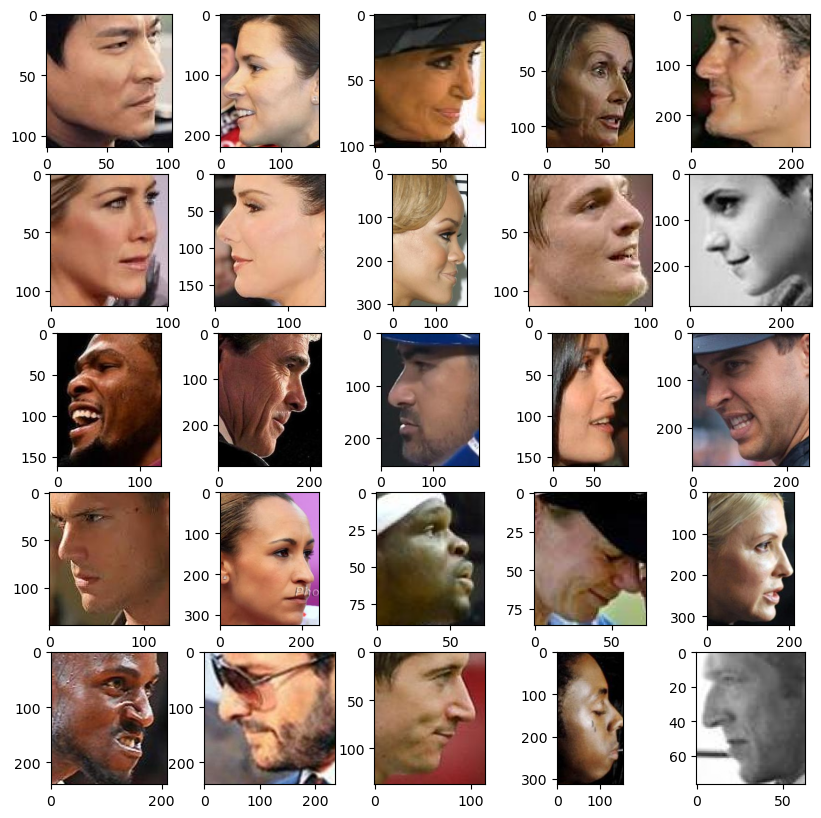

In [8]:
plot_images_in_path('/mnt/hdd/__Docencia/DataAnalysisWithPython/!!2023SepUH/lectures/large_datasets/face_front_profile/profile')

Configure the train and testing generator, including data augmentation

In [9]:
# Data Augmentation with ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Create the data generator
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,
    width_shift_range=0.25,
    height_shift_range=0.25,
#     shear_range=15,
    zoom_range=[0.5, 1.5],
    validation_split=0.2  # 30% for testing
)

# Generators for training and testing sets
data_gen_training = datagen.flow_from_directory('data/face_front_profile', target_size=(224, 224),
                                                batch_size=32, shuffle=True, subset='training')
data_gen_testing = datagen.flow_from_directory('data/face_front_profile', target_size=(224, 224),
                                               batch_size=32, shuffle=True, subset='validation')

Found 600 images belonging to 1 classes.
Found 149 images belonging to 1 classes.


Show examples of augmented data

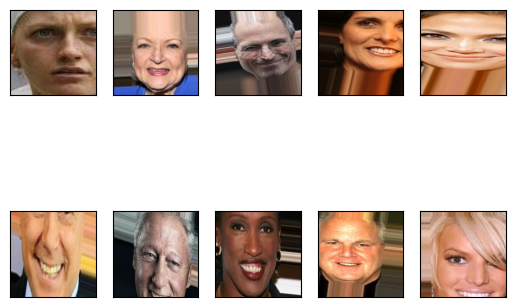

In [10]:
# Print 10 images from the training generator
for image, label in data_gen_training:
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image[i])
    break
plt.show()

In [11]:
# !pip install tensorflow_hub

In [13]:
import tensorflow_hub as hub

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))

Now lets freeze the feature model

In [ ]:
mobilenetv2.trainable = False

Now add the dense later to the model

In [ ]:
model = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
model.summary()

Now compile the model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Callbacks are useful for many things. Here, we use it for saving models at different epochs

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath="frontal_profile_{epoch:02d}.h5",  # File name with epoch number
    save_weights_only=False,  # Save the entire model, not just the weights
    period=5  # Save the model every 10 epochs
)

#Entrenar el modelo
EPOCHS = 20

# history = model.fit(
#     data_gen_training, epochs=EPOCHS, batch_size=32,
#     validation_data=data_gen_testing, 
#     callbacks=[checkpoint_callback]
# )

In [ ]:
from tensorflow.keras.models import load_model

trained_model = load_model('frontal_profile_20.h5', custom_objects={'KerasLayer': hub.KerasLayer})
trained_model.evaluate(data_gen_testing)